In [1]:
import dataclasses
import pickle
import random
import numpy as np
import os
import re
import time
from annoy import AnnoyIndex
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist, pdist, squareform, euclidean
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine as cos_dist
from sklearn.preprocessing import normalize
from gensim import models

from matplotlib import pyplot as plt
from typing import *

In [2]:
def read_goog_file(data_dir: str='.', size: int=None, clean=False) -> Tuple[List[str], np.array]:
    """
    Read the 3M vectors of length 300 from the Google News dataset. 
    
    Returns a list of words and a matrix of vectors. Indices match between the two.
    The vectors are normalized to unit, because Semantle uses cos distance which ignores magnitude.
    
    data_dir: dir that contains source files
    'size' and 'clean' will produce fewer rows.
    size: a number smaller than 3 million. Stops reading once we hit that many rows.
    clean: only keep high-quality words (no spaces, numbers, capital letters, or non-ascii.)
    """
    vec_file = os.path.join(data_dir + 'GoogleNews-vectors-negative300.bin')
    kv = models.KeyedVectors.load_word2vec_format(vec_file, binary=True, limit=size)
    words = kv.index_to_key
    vecs = []
    w_list = []
    
    # subset setup
    if clean:
        ascii_subset = re.compile(r'^[a-z]+$')

    # iterate over file
    for w in words:
        if clean:
            # filter out proper nouns, pictograms, emoji, multi-words, etc. Eliminates 95% of the dataset.   
            if not ascii_subset.match(w):
                continue
        w_list.append(w)
        vecs.append(kv[w])
    
    # combine, normalize, return
    mat = np.vstack(vecs)
    return w_list, normalize(mat, axis=1)



In [3]:
data_dir = '/mnt/Spookley/datasets/semantle/'
w_list, mat_orig = read_goog_file(data_dir=data_dir, clean=True)
print('w_list size:', len(w_list), 'mat shape:', mat_orig.shape)

w_list size: 155060 mat shape: (155060, 300)


### core semantle-solver stuff


In [55]:
def random_point_in_dist(point, dist):
    # For when we know the dist but have no idea what direction to travel
    vec = np.random.random((len(point)))
    vec = vec / scipy.linalg.norm(vec)
    vec = vec * dist*0.5
    return vec+point


def directed_point_in_dist(p1, p2, p1_dist, p2_dist, speed=1.0):
    # Generate a vector using p1 and p2.
    # Check if it will point in the general direction of our target.
    p1p2 = (p1-p2)
    p1p2mag = scipy.linalg.norm(p1p2)
    if p1p2mag < 0.0000001:
        return None, 0
    p1p2_unit = p1p2 / p1p2mag
    if p1_dist < p2_dist:
        # p1 is closer to target
        mag = p1_dist
        target_point = p1 + p1p2_unit*mag*speed
        confidence = (p2_dist-p1_dist) / p1p2mag
        assert confidence >= 0
    else:
        # j is closer to target
        # make a vector from j to a target that is dists[j] away
        mag = p2_dist
        target_point = p2 - p1p2_unit*mag*speed
        confidence = (p1_dist-p2_dist) / p1p2mag
        assert confidence >= 0
    return target_point, confidence

In [5]:
def score_to_dist(score: float, curve: np.array):
    c_dist = 1 - (score / 100)
    polyfunc = np.poly1d(curve)
    return polyfunc(c_dist)


In [6]:
"""
Class for looking up word vectors in original or reduced space.
Used by both Game and Player classes.
"""
@dataclasses.dataclass
class WordInfo:
    mat_orig: np.array
    mat_reduced: np.array
    curve: np.array
    word_to_idx: Dict[str, int]
    w_list: List[str]
    ann_index: AnnoyIndex
        

In [7]:
def build_index(w_list: List[str], mat_reduced: np.array) -> AnnoyIndex:    
    ann_index = AnnoyIndex(mat_reduced.shape[1], 'euclidean')
    with tqdm(total=len(w_list)) as pbar:
        for i, w in enumerate(w_list):
            pbar.update(1)
            ann_index.add_item(i, mat_reduced[i, :])
    ann_index.build(20) # n trees
    return ann_index

In [31]:
class SemantleGame():
    def __init__(self, info: WordInfo, target_list=None):
        if target_list:
            self.target_word = random.choice(target_list)
        else:
            self.target_word = random.choice(info.w_list)
        idx = info.word_to_idx[self.target_word]
        self.target_vec = info.mat_orig[idx, :]
        
    def guess(self, word, info: WordInfo) -> Tuple[bool, float]:
        # construct guess
        idx = info.word_to_idx[word]
        vec = info.mat_orig[idx, :]
        semantle_score = (1-cos_dist(vec, self.target_vec))*100
        if word == self.target_word:
            return True, semantle_score
        else:
            return False, semantle_score
    
    def display_guesses(self):
        s = []
        for g in sorted(self.guesses, key = lambda g: g.dist):
            s.append(str(g))
        print('\n'.join(s))
        
    def __str__(self):
        return '\n'.join('{}: {}'.format(k, v) for k, v in self.__dict__.items())

In [86]:
@dataclasses.dataclass
class Guess:
    word: str
    num: int
    dist: float
    score: float
    
class SemantleSolver:
    
    def __init__(self, info: WordInfo, 
                 n_random_guesses=5, conf_thresh=0.1):
        
        self.n_random_guesses = n_random_guesses
        self.conf_thresh = conf_thresh
        
        self.guesses = []  # List[Guess]
        self.guessed_words = set()  # for fast lookup
        self.best_guess = None
        self.closest_dist = float('inf')
        
        self.stats = {
            'grd_high_conf': 0,
            'grd_random_dist': 0,
            'times_gradient': 0,
            'times_exhaustive': 0,
            'times_random': 0,
        }
        
    def _gradient_method(self, info: WordInfo):
        # Use gradient method to get a closer guess.
        w1 = self.guesses[-1].word
        idx1 = info.word_to_idx[w1]
        p1 = info.mat_reduced[idx1, :]
        p1_dist = self.guesses[-1].dist
        
        # Consider the few most recent points. 
        # Try and find one with a vector through p1 that points towards the target.
        best_point = None
        best_confidence = 0
        
        """
        
        
        this window thing matters a lot, tune it!
        
        
        
        """
        window = min(100, len(self.guesses))
        for i in range(2, window):
            w2 = self.guesses[-i].word
            idx2 = info.word_to_idx[w2]
            p2 = info.mat_reduced[idx2, :]
            p2_dist = self.guesses[-i].dist
            
            # where does p2->p1 point? and how well aligned is that spot with the target?
            target_point, confidence = directed_point_in_dist(p1, p2, p1_dist, p2_dist)
            if confidence > best_confidence:
                best_confidence = confidence
                best_point = target_point
        if best_confidence < self.conf_thresh:
            # Low confidence in all computed directions. Let's pick a random direction and hope 
            # it gives us some new information.
            self.stats['grd_random_dist'] += 1
            idx_best = info.word_to_idx[self.best_guess]
            vec = np.array(info.mat_reduced[idx_best, :])
            best_point = random_point_in_dist(vec, self.closest_dist)
        else:
            self.stats['grd_high_conf'] += 1

        return best_point

    
    def find_next_guess(self, info: WordInfo) -> bool:
        if len(self.guesses) < self.n_random_guesses:
            self.stats['times_random'] += 1
            next_word = random.choice(info.w_list)
        else:
            self.stats['times_gradient'] += 1
            v = self._gradient_method(info)
            idxs_near_best = info.ann_index.get_nns_by_vector(v, 1000)
            next_word = None
            for idx in idxs_near_best:
                w = info.w_list[idx]
                if w not in self.guessed_words:
                    next_word = w
                    break
            if next_word is None:
                # If we've guessed 1000 points near this target already, just
                # guess anything. If we hit this point, probably this solver param set is trash.
                next_word = random.choice(info.w_list)
            
        return next_word

    def make_guess(self, word, info: WordInfo, game: SemantleGame):
        # guess the word
        win, score = game.guess(word, info)
        dist = score_to_dist(score, info.curve)
        self.guessed_words.add(word)
        self.guesses.append(Guess(word=word, dist=dist, num=len(self.guesses)+1, score=score))
        
        # see if this one's better
        if self.best_guess is None or dist < self.closest_dist:
            #print(word, round(dist, 3))
            self.closest_dist = dist
            self.best_guess = word
        
        if win:
            #print("I win!")
            return True
        else:
            return False
    
    def add_guess(self, word, score):
        # Adds a guess from an external source. For playing Real Semantle.
        dist = score_to_dist(score, self.curve)
        self.guessed_words.add(word)
        self.guesses.append(Guess(word=word, dist=dist, num=len(self.guesses)+1, score=score))
        if self.best_guess is None or dist < self.closest_dist:
            #print(word, round(dist, 3))
            self.closest_dist = dist
            self.best_guess = word
        

In [77]:
def run_solver(info: WordInfo):
    target_list = []
    w_set = set(w_list)
    with open(os.path.join(data_dir, 'en_10k.txt')) as fh:
        for w in fh.read().split('\n'):
            w = w.strip()
            if w in w_set:
                target_list.append(w)

    game = SemantleGame(info, target_list=target_list)
    player = SemantleSolver(info, n_random_guesses=10, conf_thresh=0.1)
    print(game.target_word)
    won = False
    while not won:
        word = player.find_next_guess(info)
        won = player.make_guess(word, info, game)
        g = player.guesses[-1]
        local_dist = score_to_dist(g.score, curve)
        #print(g.word, round(g.score, 3), '->', round(local_dist, 3))
        if len(player.guesses) >= 1000:
            print('stopped. word was:', game.target_word)
            #print('Best guess:', player.best_guess, 'dist:', player.closest_dist)
            break
    #print(player.stats)

    max_score = 0
    traj = []
    for g in player.guesses:
        max_score = max(g.score, max_score)
        traj.append(max_score)
        
    plt.plot(range(len(traj)), traj, '-')
    plt.xlim(0, 1000)
    plt.ylim(0, 100)
    plt.title('PCA trajectories, n_dims={}, n_rows={}'.format(n_dims, len(info.w_list)))
    plt.ylabel('Max score so far, 100=win')
    plt.xlabel('Guess number, 1000=lose')
    #dists = [g.dist for g in player.guesses]
    #print(min(dists), max(dists), np.mean(dists))
    return won

  0%|          | 0/155060 [00:00<?, ?it/s]

sable
speculation
mourning
recognition
earnest
tidy
ours
learn
miscellaneous
heartbroken
guardian
washing
attorney
awesome
horizontal
cleft
purchase
decline
symphony
proportion
dietary
proverb
oddly
infuriate
differently
weather
about
footwear
nanny
parity
evict
comprise
banker
homicidal
thankful
plea
electronic
presence
glutton
enthusiastic
brandy
squirrel
pose
noisy
cabinet
ham
expelled
younger
leopard
worries
infamous
police
coax
prefer
commonplace
boiling
script
component
doom
display
forty
bedridden
minimum
intern
familiar
sex
flashy
poem
swine
speechless
octopus
cornered
sport
fond
dub
numeral
repulsive
marshal
large
rift
flake
reptile
outward
pollute
jackal
block
specialist
monkey
seaside
potato
eyelash
change
lantern
saving
hold
jackpot
why
holiday
pageant
pioneer
100.0 % success


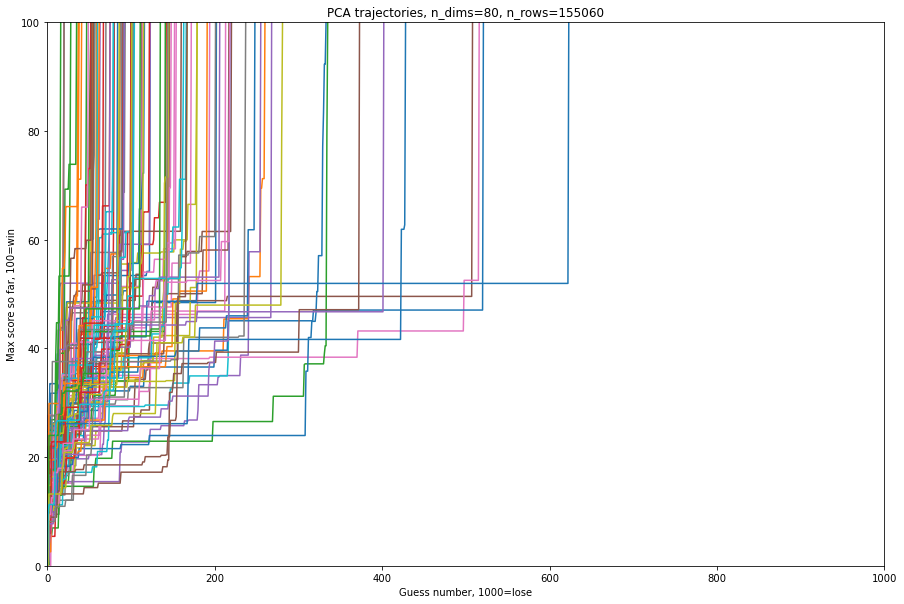

In [87]:
# Load in each PCA matrix and its curve
# build an ANN index on that PCA
# then play a bunch of games to see how well it does
n_rows = len(w_list)
pf_file = os.path.join(data_dir, 'pca_curve_fits_{}rows.pkl'.format(n_rows))
with open(pf_file, 'rb') as fh:
    curves = pickle.load(fh)
    
for n_dims in [80]:
    fn = os.path.join(data_dir, 'pca_{}rows_{}dims.npy'.format(n_rows, n_dims))
    curve = curves[n_dims]
    mat_pca = np.load(fn)
    
    ann_index = build_index(w_list, mat_pca)
    
    info = WordInfo(
        mat_orig = mat_orig,
        mat_reduced = mat_pca,
        curve = curve,
        word_to_idx = {w:idx for idx, w in enumerate(w_list)},
        w_list = w_list,
        ann_index = ann_index
    )
    plt.figure(figsize=(15,10))
    plt.title('PCA solver, {} dims {} rows'.format(n_dims, n_rows))
    
    wins = 0
    runs = 100
    for _ in range(runs):
        if run_solver(info):
            wins += 1
    print(round(wins/runs*100, 2), '% success')